In [3]:
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime

yf.pdr_override()

df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show the data
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.500193,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.567368,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.706893,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.839732,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.819363,394024400


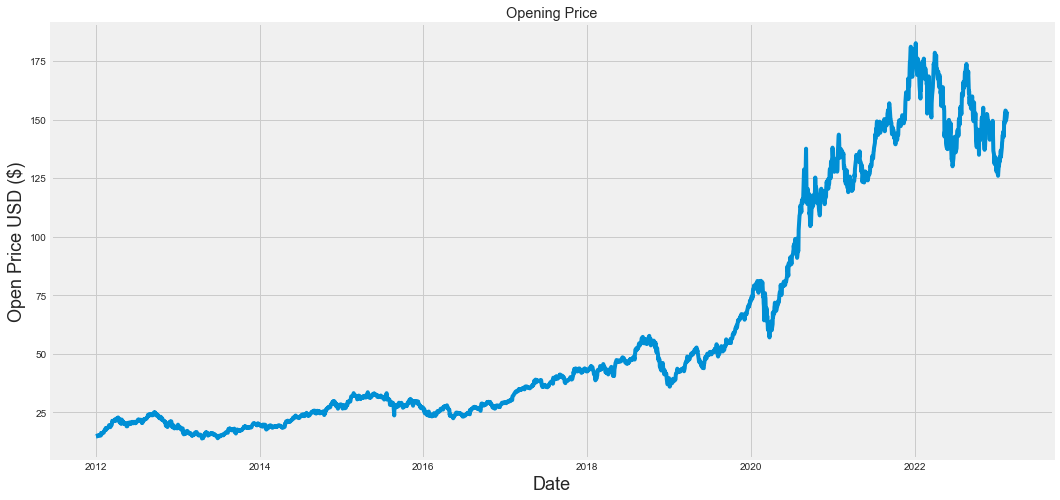

In [4]:
plt.figure(figsize=(16,8))
plt.title('Opening Price')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

In [5]:
data=df.filter(['Open'])

#Convert to np array
dataset=data.values

#Get the number of rows to train the model on & math.ceil to round up 
training_data_len = math.ceil(len(dataset)*.8)

#print(dataset)
training_data_len

2240

In [6]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

#Create scaled training dataset
train_data = scaled_data[0:training_data_len,:]

#Split the data into x_train and y_train data set
x_train=[]
y_train=[]
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00453481, 0.00466177, 0.00570924, 0.00672921, 0.00794173,
       0.00802849, 0.00734499, 0.00726035, 0.0067144 , 0.00766664,
       0.00825068, 0.00892572, 0.00836283, 0.00734287, 0.00785709,
       0.01406573, 0.01277914, 0.01192847, 0.01221837, 0.01430908,
       0.01490582, 0.01437468, 0.01467094, 0.01489947, 0.01635324,
       0.01746419, 0.01963531, 0.02179374, 0.02360723, 0.02469279,
       0.02672425, 0.02190801, 0.0243648 , 0.02516257, 0.02647455,
       0.02689777, 0.02786906, 0.0282161 , 0.02962331, 0.03250121,
       0.03389995, 0.03306833, 0.03331803, 0.02871339, 0.03149395,
       0.03104745, 0.03306198, 0.03407136, 0.03588275, 0.04022287,
       0.04478518, 0.0416343 , 0.04452279, 0.04476402, 0.04544752,
       0.04439793, 0.0449714 , 0.04482326, 0.04617546, 0.0487571 ])]
[0.047572090040578996]



In [7]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2180, 60, 1)

In [9]:
#Build LSTM model
model=Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1,epochs=3)

Epoch 1/3
2180/2180 [==============================] - 36s 15ms/step - loss: 7.9030e-04
Epoch 2/3
2180/2180 [==============================] - 31s 14ms/step - loss: 3.1024e-04
Epoch 3/3
2180/2180 [==============================] - 32s 15ms/step - loss: 2.4359e-04


In [10]:
#Create the test data set
#Create a new array containing scaled values
test_data=scaled_data[training_data_len-60: , : ]

#Create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
#Convert the data to a numpy array
x_test=np.array(x_test)
#Reshape the data to 3d
x_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))
#Get the models predicted price values

predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)
#Get root mean squared error(RMSE)
rmse =np.sqrt(np.mean(predictions-y_test)**2)
rmse

18/18 [==============================] - 1s 10ms/step


2.9759046827043805

<ipython-input-13-f6fc7f3a4721>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


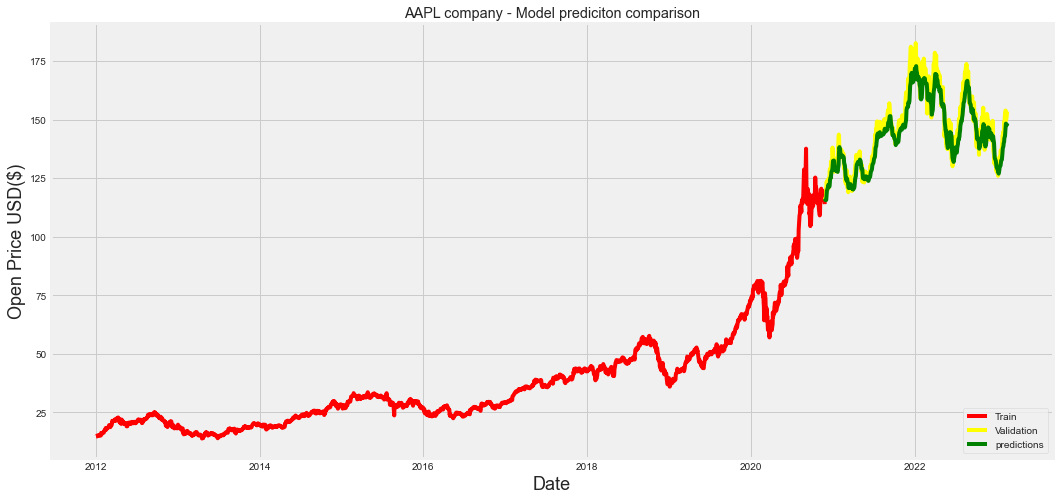

In [13]:
#plot the data

train=data[:training_data_len]
valid=data[training_data_len:]
valid['predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('AAPL company - Model prediciton comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train['Open'] , color='red')
plt.plot(valid['Open'] , color='yellow')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'predictions'], loc='lower right')
plt.show()

In [14]:
#Show the valid and predicted prices
valid.tail(15)

,Open,predictions
Date,,
2023-01-27,143.160004,137.659805
2023-01-30,144.960007,138.724274
2023-01-31,142.699997,139.864365
2023-02-01,143.970001,140.154999
2023-02-02,148.899994,140.498184
2023-02-03,148.029999,141.944046
2023-02-06,152.570007,143.028427
2023-02-07,150.639999,144.874069
2023-02-08,153.880005,145.898590


### Getting predicitions - for tomorrow

In [15]:
#Get the quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# end='2023-02-15'

new_df=df.filter(['Open'])
#Get last 60 days values and convert into array
last_60_days=new_df[-60:].values

#Scale the data to be values between 0
last_60_days_scaled=scaler.transform(last_60_days)

#Create an empty list
X_test=[]
#Appemd the past 60days
X_test.append(last_60_days_scaled)

#Conver the X_test data into numpy array
X_test = np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(f'Opening Price of AAPL tomorrow:{pred_price}')

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 84ms/step
Opening Price of AAPL tomorrow:[[148.878]]
